# **Sanvia: AI for Early Hope - Notebook 1**
**Data & Preprocessing Pipeline for VinDr-Mammo**

Preamble and Environment Setup

In [ ]:
import os
import sys
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from pathlib import Path
from typing import Dict, List, Tuple, Optional
import json
import pickle
from datetime import datetime

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['PYTHONHASHSEED'] = str(SEED)

print(f"Python: {sys.version}")
print(f"TensorFlow: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
TensorFlow: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Colab-Specific Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
DATA_DIR = Path('/content/drive/MyDrive/VnDir_Mammo')

In [ ]:
!pip install -q albumentations python-docx reportlab seaborn

Import Libraries

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import cv2
import albumentations as A
from albumentations.core.composition import Compose

# Configure matplotlib for high-res figures
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300

Global Configuration

In [ ]:
CONFIG = {
    # Paths
    'data_dir': DATA_DIR,
    'metadata_csv': DATA_DIR / 'metadata.csv',
    'breast_annotations_csv': DATA_DIR / 'breast-level_annotations.csv',
    'finding_annotations_csv': DATA_DIR / 'finding_annotations.csv',
    'images_dir': DATA_DIR / 'images' / 'images_png',

    # Output directories
    'output_dir': DATA_DIR / 'sanvia_outputs',
    'scaler_path': DATA_DIR / 'sanvia_outputs' / 'age_scaler.pkl',
    'class_weights_path': DATA_DIR / 'sanvia_outputs' / 'class_weights.json',
    'config_path': DATA_DIR / 'sanvia_outputs' / 'config.json',

    # Data splits
    'valid_fraction': 0.5,  # 50% of test set for validation
    'test_split_name': 'test',  # Value in 'split' column for test

    # Image parameters
    'img_size': (512, 512),  # EfficientNet-B4 input size
    'num_channels': 3,
    'dtype': tf.float32,

    # Model parameters
    'backbone': 'EfficientNetB4',
    'tab_embed_dim': 128,

    # Training parameters
    'batch_size': 4,  # Adjust based on GPU memory (Colab Pro+)
    'buffer_size': 1000,
    'prefetch_buffer': tf.data.AUTOTUNE,

    # Augmentation parameters
    'augment_prob': 0.7,
    'rotation_limit': 7,  # degrees
    'brightness_limit': 0.15,
    'contrast_limit': 0.15,
    'shift_scale_limit': 0.1,

    # Oversampling
    'oversample_factor': 2.0,  # Multiplier for rare class sampling

    # Labels
    'birads_classes': 5,  # BI-RADS 1-5
    'density_classes': 4,  # A, B, C, D
    'finding_classes': ['mass', 'calcification', 'architectural_distortion'],

    # Class weights
    'focal_gamma': 2.0,
    'focal_alpha': 0.25,

    # Random seed
    'seed': 42,
}

# Create output directory
CONFIG['output_dir'].mkdir(parents=True, exist_ok=True)

# Save config for later notebooks
with open(CONFIG['config_path'], 'w') as f:
    json.dump(CONFIG, f, indent=2, default=str, sort_keys=True)

print("Configuration:")
print(json.dumps(CONFIG, indent=2, default=str))

Configuration:
{
  "data_dir": "/content/drive/MyDrive/VnDir_Mammo",
  "metadata_csv": "/content/drive/MyDrive/VnDir_Mammo/metadata.csv",
  "breast_annotations_csv": "/content/drive/MyDrive/VnDir_Mammo/breast-level_annotations.csv",
  "finding_annotations_csv": "/content/drive/MyDrive/VnDir_Mammo/finding_annotations.csv",
  "images_dir": "/content/drive/MyDrive/VnDir_Mammo/images/images_png",
  "output_dir": "/content/drive/MyDrive/VnDir_Mammo/sanvia_outputs",
  "scaler_path": "/content/drive/MyDrive/VnDir_Mammo/sanvia_outputs/age_scaler.pkl",
  "class_weights_path": "/content/drive/MyDrive/VnDir_Mammo/sanvia_outputs/class_weights.json",
  "config_path": "/content/drive/MyDrive/VnDir_Mammo/sanvia_outputs/config.json",
  "valid_fraction": 0.5,
  "test_split_name": "test",
  "img_size": [
    512,
    512
  ],
  "num_channels": 3,
  "dtype": "<dtype: 'float32'>",
  "backbone": "EfficientNetB4",
  "tab_embed_dim": 128,
  "batch_size": 4,
  "buffer_size": 1000,
  "prefetch_buffer": -1,
  "

Load and Explore CSV Data

In [ ]:
def load_vindr_data(config: Dict) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    # Load metadata
    if not config['metadata_csv'].exists():
        raise FileNotFoundError(f"Metadata CSV not found: {config['metadata_csv']}")
    metadata_df = pd.read_csv(config['metadata_csv'])
    print(f"Metadata shape: {metadata_df.shape}")

    # Load breast-level annotations
    if not config['breast_annotations_csv'].exists():
        raise FileNotFoundError(f"Breast annotations CSV not found: {config['breast_annotations_csv']}")
    breast_df = pd.read_csv(config['breast_annotations_csv'])
    print(f"Breast annotations shape: {breast_df.shape}")

    # Load finding annotations if available
    finding_df = None
    if config['finding_annotations_csv'].exists():
        finding_df = pd.read_csv(config['finding_annotations_csv'])
        print(f"Finding annotations shape: {finding_df.shape}")
    else:
        print("Warning: Finding annotations CSV not found. Proceeding without findings.")

    return metadata_df, breast_df, finding_df

# Load data
metadata_df, breast_df, finding_df = load_vindr_data(CONFIG)

# Show sample
display(breast_df.head())

Metadata shape: (20000, 21)
Breast annotations shape: (20000, 10)
Finding annotations shape: (20486, 16)


,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,split
0,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,d8125545210c08e1b1793a5af6458ee2,L,CC,3518,2800,BI-RADS 2,DENSITY C,training
1,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,290c658f4e75a3f83ec78a847414297c,L,MLO,3518,2800,BI-RADS 2,DENSITY C,training
2,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,cd0fc7bc53ac632a11643ac4cc91002a,R,CC,3518,2800,BI-RADS 2,DENSITY C,training
3,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,71638b1e853799f227492bfb08a01491,R,MLO,3518,2800,BI-RADS 2,DENSITY C,training
4,8269f5971eaca3e5d3772d1796e6bd7a,d931832a0815df082c085b6e09d20aac,dd9ce3288c0773e006a294188aadba8e,L,CC,3518,2800,BI-RADS 1,DENSITY C,training


In [ ]:
print(breast_df['breast_birads'].unique()[:5000])
print(breast_df['breast_density'].unique()[:5000])

['BI-RADS 2' 'BI-RADS 1' 'BI-RADS 3' 'BI-RADS 4' 'BI-RADS 5']
['DENSITY C' 'DENSITY B' 'DENSITY D' 'DENSITY A']


Data Quality Checks and Cleaning

In [ ]:
def clean_and_validate_data(metadata_df: pd.DataFrame,
                           breast_df: pd.DataFrame,
                           finding_df: Optional[pd.DataFrame]) -> Tuple[pd.DataFrame, pd.DataFrame, Optional[pd.DataFrame]]:
    # Check for required columns
    required_breast_cols = ['study_id', 'series_id', 'laterality', 'view_position',
                           'breast_birads', 'breast_density', 'split']
    missing_cols = set(required_breast_cols) - set(breast_df.columns)
    if missing_cols:
        raise ValueError(f"Missing required columns in breast annotations: {missing_cols}")

    # --- Clean breast_birads (should be 1-5) ---
    # Extract digit from strings like "BI-RADS 3"
    breast_df['breast_birads'] = (
        breast_df['breast_birads']
        .astype(str)
        .str.extract(r'(\d)')
        .astype(float)
    )
    birads_invalid = ~breast_df['breast_birads'].isin([1, 2, 3, 4, 5])
    if birads_invalid.any():
        print(f"Warning: {birads_invalid.sum()} invalid BI-RADS values found. Dropping rows.")
        breast_df = breast_df[~birads_invalid]
    breast_df['breast_birads'] = breast_df['breast_birads'].astype(int)

    # --- Clean breast_density (should be A-D) ---
    # Extract letter from strings like "Density C"
    breast_df['breast_density'] = (
        breast_df['breast_density']
        .astype(str)
        .str.extract(r'([A-D])')
    )
    density_map = {'A': 0, 'B': 1, 'C': 2, 'D': 3}
    breast_df['breast_density'] = breast_df['breast_density'].map(density_map)
    density_invalid = breast_df['breast_density'].isna()
    if density_invalid.any():
        print(f"Warning: {density_invalid.sum()} invalid density values found. Dropping rows.")
        breast_df = breast_df[~density_invalid]
    breast_df['breast_density'] = breast_df['breast_density'].astype(int)

    # Ensure unique study_id + laterality + view_position
    duplicates = breast_df.groupby(['study_id', 'laterality', 'view_position']).size()
    duplicates = duplicates[duplicates > 1]
    if len(duplicates) > 0:
        print(f"Warning: {len(duplicates)} duplicate view entries found. Keeping first occurrence.")
        breast_df = breast_df.drop_duplicates(subset=['study_id', 'laterality', 'view_position'])

    # Clean metadata
    if 'age' not in metadata_df.columns:
        print("Warning: 'age' column not found in metadata. Creating placeholder.")
        metadata_df['age'] = np.nan

    return metadata_df, breast_df, finding_df
print(f"Cleaned breast annotations shape: {breast_df.shape}")
print(f"Cleaned breast annotations shape: {finding_df.shape}")
print(f"Cleaned breast annotations shape: {metadata_df.shape}")

Cleaned breast annotations shape: (20000, 10)
Cleaned breast annotations shape: (20486, 16)
Cleaned breast annotations shape: (20000, 21)


Prepare Finding Labels

In [ ]:
def prepare_finding_labels(finding_df: Optional[pd.DataFrame],
                          config: Dict) -> Optional[pd.DataFrame]:
    if finding_df is None:
        print("No finding annotations available. Skipping finding label preparation.")
        return None

    print("Preparing finding labels...")

    # Create binary columns for each finding type
    for finding in config['finding_classes']:
        finding_df[finding] = 0

    # Example parsing logic (adjust based on actual data format)
    for idx, row in finding_df.iterrows():
        if pd.notna(row.get('finding_categories')):
            try:
                # Try to evaluate if it's a string representation of list
                cats = eval(row['finding_categories'])
                for cat in cats:
                    if cat in config['finding_classes']:
                        finding_df.at[idx, cat] = 1
            except:
                # If it's a simple string
                cat = row['finding_categories']
                if cat in config['finding_classes']:
                    finding_df.at[idx, cat] = 1

    # Aggregate per image_id (multiple findings possible)
    finding_agg = finding_df.groupby('image_id')[config['finding_classes']].max().reset_index()

    print(f"Finding labels prepared: {finding_agg.shape}")
    return finding_agg

# Prepare finding labels
finding_labels_df = prepare_finding_labels(finding_df, CONFIG)

Preparing finding labels...
Finding labels prepared: (20000, 4)


Patient-Level Splitting

In [ ]:
def create_patient_splits(breast_df: pd.DataFrame, config: Dict) -> pd.DataFrame:
    print("Creating patient-level splits...")

    # Get unique studies
    studies = breast_df['study_id'].unique()
    print(f"Total unique studies: {len(studies)}")

    # Identify test studies
    test_studies = breast_df[breast_df['split'] == config['test_split_name']]['study_id'].unique()
    print(f"Test studies (from split column): {len(test_studies)}")

    # Determine remaining studies for training
    train_studies = np.setdiff1d(studies, test_studies)
    print(f"Train studies: {len(train_studies)}")

    # Split test into validation and final test
    valid_studies, final_test_studies = train_test_split(
        test_studies,
        test_size=1-config['valid_fraction'],
        random_state=config['seed']
    )
    print(f"Validation studies: {len(valid_studies)}")
    print(f"Final test studies: {len(final_test_studies)}")

    # Assign split labels
    breast_df['split_final'] = 'train'
    breast_df.loc[breast_df['study_id'].isin(valid_studies), 'split_final'] = 'val'
    breast_df.loc[breast_df['study_id'].isin(final_test_studies), 'split_final'] = 'test'

    # Verify no leakage
    for split_name in ['train', 'val', 'test']:
        split_studies = set(breast_df[breast_df['split_final'] == split_name]['study_id'])
        print(f"{split_name} split: {len(split_studies)} studies")

    # Check for overlap
    assert len(set(train_studies) & set(valid_studies) & set(final_test_studies)) == 0, "Data leakage detected!"

    return breast_df

# Create splits
breast_df = create_patient_splits(breast_df, CONFIG)
print("\nSplit distribution:")
print(breast_df['split_final'].value_counts())

Creating patient-level splits...
Total unique studies: 5000
Test studies (from split column): 1000
Train studies: 4000
Validation studies: 500
Final test studies: 500
train split: 4000 studies
val split: 500 studies
test split: 500 studies

Split distribution:
split_final
train    16000
test      2000
val       2000
Name: count, dtype: int64


Merge Tabular Data (Age)

In [ ]:
# إزالة اللاحقة .png من أسماء الصور
breast_df["image_name_no_ext"] = breast_df["image_id"].str.replace(".png", "", regex=False)

# حساب نسبة التطابق بين اسم الصورة و SOP Instance UID
match_ratio = breast_df["image_name_no_ext"].isin(metadata_df["SOP Instance UID"]).mean()

print(f"نسبة التطابق بين أسماء الصور و SOP Instance UID: {match_ratio*100:.2f}%")

نسبة التطابق بين أسماء الصور و SOP Instance UID: 100.00%


In [ ]:
# تنظيف عمود العمر من صيغة مثل "053Y"
metadata_df["age"] = (
    metadata_df["Patient's Age"]
    .astype(str)              # تأكد أنه نص
    .str.extract(r'(\d+)')    # استخراج الرقم فقط
    .astype(float)            # تحويل إلى رقم
)

# عرض أول 20 قيمة بعد التنظيف
print("أول 20 قيمة بعد التنظيف:", metadata_df["age"].head(20).tolist())

# عرض إحصائيات الأعمار
print("\nإحصائيات الأعمار بعد التنظيف:")
print(metadata_df["age"].describe())

# عرض بعض القيم الفريدة
print("\nقيم الأعمار الفريدة:", metadata_df["age"].unique()[:50])

أول 20 قيمة بعد التنظيف: [53.0, 53.0, 53.0, 53.0, 42.0, 42.0, 42.0, 42.0, 50.0, 50.0, 50.0, 50.0, 35.0, 35.0, 35.0, 35.0, 38.0, 38.0, 38.0, 38.0]

إحصائيات الأعمار بعد التنظيف:
count    17740.000000
mean        44.119053
std         11.698422
min          0.000000
25%         38.000000
50%         45.000000
75%         51.000000
max         88.000000
Name: age, dtype: float64

قيم الأعمار الفريدة: [53. 42. 50. 35. 38. 46. 58. 47. 52. 59. 36. 41. 45. 55. 51. 48. 30. 49.
 43. 39. 32. 33. 56. 44. 61. 63. 60. 31. 29. 40. 57. 28. 54. 68. 34. 37.
 62. 64. 27. 67. 65. 25. 14. 70. 74. 77. 26. 72. 69. 24.]


In [ ]:
import os
import numpy as np
import pandas as pd

def merge_tabular_features(breast_df: pd.DataFrame,
                          metadata_df: pd.DataFrame,
                          config: CONFIG,
                          images_root="images") -> pd.DataFrame:
    """Merge age using SOP Instance UID <-> image filename (without .png)."""

    print("Merging tabular features (age)...")

    # تأكد أن عمود age موجود
    if "age" not in metadata_df.columns:
        raise ValueError("عمود 'age' غير موجود في metadata_df. تأكد من تنظيف الأعمار أولاً.")

    # --- تجهيز metadata ---
    metadata_subset = metadata_df[["SOP Instance UID", "age"]].copy()

    # إزالة اللاحقة .png من أسماء الصور في breast_df
    breast_df["image_name_no_ext"] = breast_df["image_id"].str.replace(".png", "", regex=False)

    # إعادة تسمية SOP Instance UID ليطابق اسم الصورة
    metadata_subset.rename(columns={"SOP Instance UID": "image_name_no_ext"}, inplace=True)

    # إزالة التكرارات
    metadata_subset = metadata_subset.drop_duplicates(subset=["image_name_no_ext"])

    # --- معالجة الأعمار المفقودة ---
    age_median = metadata_subset["age"].median(skipna=True)
    metadata_subset["age_missing_flag"] = metadata_subset["age"].isna().astype(int)
    metadata_subset["age"] = metadata_subset["age"].fillna(age_median)

    print(f"Median age for imputation: {age_median:.1f}")
    print(f"Missing age count: {metadata_subset['age_missing_flag'].sum()}")

    # --- الدمج باستخدام اسم الصورة بدون اللاحقة ---
    merged_df = breast_df.merge(
        metadata_subset,
        on="image_name_no_ext",
        how="left",
        validate="many_to_one"
    )

    # معالجة أي أعمار مفقودة بعد الدمج
    if merged_df["age"].isna().any():
        print("Warning: Some images not found in metadata. Using global median.")
        merged_df["age"] = merged_df["age"].fillna(age_median)
        merged_df["age_missing_flag"] = merged_df["age_missing_flag"].fillna(1).astype(int)

    return merged_df
# Merge features
merged_df = merge_tabular_features(breast_df, metadata_df, CONFIG)
print(f"Merged dataframe shape: {merged_df.shape}")
display(merged_df.head())

Merging tabular features (age)...
Median age for imputation: 45.0
Missing age count: 2260
Merged dataframe shape: (20000, 14)


,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,split,split_final,image_name_no_ext,age,age_missing_flag
0,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,d8125545210c08e1b1793a5af6458ee2,L,CC,3518,2800,BI-RADS 2,DENSITY C,training,train,d8125545210c08e1b1793a5af6458ee2,53.0,0
1,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,290c658f4e75a3f83ec78a847414297c,L,MLO,3518,2800,BI-RADS 2,DENSITY C,training,train,290c658f4e75a3f83ec78a847414297c,53.0,0
2,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,cd0fc7bc53ac632a11643ac4cc91002a,R,CC,3518,2800,BI-RADS 2,DENSITY C,training,train,cd0fc7bc53ac632a11643ac4cc91002a,53.0,0
3,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,71638b1e853799f227492bfb08a01491,R,MLO,3518,2800,BI-RADS 2,DENSITY C,training,train,71638b1e853799f227492bfb08a01491,53.0,0
4,8269f5971eaca3e5d3772d1796e6bd7a,d931832a0815df082c085b6e09d20aac,dd9ce3288c0773e006a294188aadba8e,L,CC,3518,2800,BI-RADS 1,DENSITY C,training,train,dd9ce3288c0773e006a294188aadba8e,42.0,0


In [ ]:
print("Unique ages:", merged_df['age'].unique()[:50])
print(merged_df['age'].describe())

Unique ages: [53. 42. 50. 35. 38. 46. 58. 47. 52. 59. 36. 41. 45. 55. 51. 48. 30. 49.
 43. 39. 32. 33. 56. 44. 61. 63. 60. 31. 29. 40. 57. 28. 54. 68. 34. 37.
 62. 64. 27. 67. 65. 25. 14. 70. 74. 77. 26. 72. 69. 24.]
count    20000.000000
mean        44.218600
std         11.021147
min          0.000000
25%         39.000000
50%         45.000000
75%         50.000000
max         88.000000
Name: age, dtype: float64


Tabular Preprocessing (Age Scaling)

In [ ]:
class TabularScaler:

    def __init__(self, features: List[str]):
        self.features = features
        self.scalers = {feat: MinMaxScaler() for feat in features}
        self.fitted = False

    def fit(self, df: pd.DataFrame):
        """Fit scalers on training data only."""
        for feat in self.features:
            self.scalers[feat].fit(df[[feat]])
        self.fitted = True

    def transform(self, df: pd.DataFrame) -> np.ndarray:
        """Transform features."""
        if not self.fitted:
            raise ValueError("Scaler must be fitted first!")

        scaled_features = []
        for feat in self.features:
            scaled = self.scalers[feat].transform(df[[feat]])
            scaled_features.append(scaled)

        return np.concatenate(scaled_features, axis=1)

    def save(self, path: Path):
        """Save scaler parameters."""
        scaler_params = {}
        for feat, scaler in self.scalers.items():
            scaler_params[feat] = {
                'min_': scaler.min_.tolist(),
                'scale_': scaler.scale_.tolist(),
                'data_min_': scaler.data_min_.tolist(),
                'data_max_': scaler.data_max_.tolist(),
                'data_range_': scaler.data_range_.tolist()
            }
        with open(path, 'wb') as f:
            pickle.dump(scaler_params, f)

    @staticmethod
    def load(path: Path) -> Dict:
        """Load scaler parameters."""
        with open(path, 'rb') as f:
            return pickle.load(f)

# Prepare tabular data
tabular_features = ['age']
tabular_scaler = TabularScaler(tabular_features)

# Fit on training data only
train_df = merged_df[merged_df['split_final'] == 'train']
tabular_scaler.fit(train_df)

# Transform all data
merged_df['age_norm'] = tabular_scaler.transform(merged_df)[:, 0]

# Save scaler
tabular_scaler.save(CONFIG['scaler_path'])
print(f"Tabular scaler saved to {CONFIG['scaler_path']}")

Tabular scaler saved to /content/drive/MyDrive/VnDir_Mammo/sanvia_outputs/age_scaler.pkl


Create View Mapping (4 views per study)

In [ ]:
def create_view_mapping(df: pd.DataFrame) -> pd.DataFrame:

    print("Creating view mapping...")

    # Verify we have exactly 4 views per study
    views_per_study = df.groupby('study_id').agg({
        'laterality': 'nunique',
        'view_position': 'nunique',
        'image_id': 'count'
    }).reset_index()

    # Most studies should have 4 views (2 lateralities × 2 positions)
    print(f"Studies with 4 views: {(views_per_study['image_id'] == 4).sum()}")
    print(f"Studies with fewer views: {(views_per_study['image_id'] < 4).sum()}")

    # For studies with missing views, we'll create placeholders
    # This is a simplified approach - in production, you might want to handle differently

    # Pivot to get one row per study
    view_map = df.pivot_table(
        index=['study_id', 'split_final'],
        columns=['laterality', 'view_position'],
        values=['image_id', 'breast_birads', 'breast_density', 'age_norm', 'age_missing_flag'],
        aggfunc='first'
    )

    # Flatten column multi-index
    view_map.columns = ['_'.join(col).strip() for col in view_map.columns]

    # Reset index
    view_map = view_map.reset_index()

    # Verify required columns exist
    required_views = ['image_id_L_CC', 'image_id_L_MLO', 'image_id_R_CC', 'image_id_R_MLO']
    missing_views = set(required_views) - set(view_map.columns)

    if missing_views:
        print(f"Warning: Missing views for some studies: {missing_views}")
        # Create dummy entries (will be handled in tf.data pipeline)
        for view in missing_views:
            view_map[view] = view_map.get(view, 'missing.png')

    return view_map

# Create view mapping
view_mapping_df = create_view_mapping(merged_df)
print(f"View mapping shape: {view_mapping_df.shape}")
display(view_mapping_df.head())

Creating view mapping...
Studies with 4 views: 5000
Studies with fewer views: 0
View mapping shape: (5000, 22)


,study_id,split_final,age_missing_flag_L_CC,age_missing_flag_L_MLO,age_missing_flag_R_CC,age_missing_flag_R_MLO,age_norm_L_CC,age_norm_L_MLO,age_norm_R_CC,age_norm_R_MLO,...,breast_birads_R_CC,breast_birads_R_MLO,breast_density_L_CC,breast_density_L_MLO,breast_density_R_CC,breast_density_R_MLO,image_id_L_CC,image_id_L_MLO,image_id_R_CC,image_id_R_MLO
0,0025a5dc99fd5c742026f0b2b030d3e9,test,0.0,0.0,0.0,0.0,0.500000,0.500000,0.500000,0.500000,...,BI-RADS 1,BI-RADS 1,DENSITY C,DENSITY C,DENSITY C,DENSITY C,451562831387e2822923204cf8f0873e,2ddfad7286c2b016931ceccd1e2c7bbc,fcf12c2803ba8dc564bf1287c0c97d9a,47c8858666bcce92bcbd57974b5ce522
1,0028fb2c7f0b3a5cb9a80cb0e1cdbb91,train,0.0,0.0,0.0,0.0,0.579545,0.579545,0.579545,0.579545,...,BI-RADS 2,BI-RADS 2,DENSITY C,DENSITY C,DENSITY C,DENSITY C,3704f91985dcbc69f6ac2803523d1ecb,7fc1f1bb8bb1a7efaf7104e49c4d8b86,c4ce68631bf70949570ded31a3c69e60,16e58fc1d65fa7587247e6224ee96527
2,0034765af074f93ed33d5e8399355caf,train,0.0,0.0,0.0,0.0,0.420455,0.420455,0.420455,0.420455,...,BI-RADS 1,BI-RADS 1,DENSITY C,DENSITY C,DENSITY C,DENSITY C,68f09c18925a66ef2840d4a62f237b31,b664cf1e7c968896144a3a2005cd3eb4,2aca993b3b6e2a32dddd170b00fd5e7d,d39964544666ed08df9aa1e9e18d1262
3,003700f3c960e0b9bca2b8437c3dbf05,train,0.0,0.0,0.0,0.0,0.500000,0.500000,0.500000,0.500000,...,BI-RADS 1,BI-RADS 1,DENSITY C,DENSITY C,DENSITY C,DENSITY C,51b47f9024ccad1356354f56ac916f29,3944b33b99c98e763763b9da54b4f41c,17c3d032d611eb3d1baf3434d62483a1,552a67df6d68b8f9498db7cadd23b0e0
4,004426a40da27ef22a866538b772ac44,train,0.0,0.0,0.0,0.0,0.568182,0.568182,0.568182,0.568182,...,BI-RADS 1,BI-RADS 1,DENSITY B,DENSITY B,DENSITY B,DENSITY B,78b8a2f4b10790d6b2a11e081eaf209a,d3ae4a0aa59a608a2823c029e988985f,7197f7e6f5ca3b9821d0460dcdc975d3,265596e3534efced063b4e656b7bd64f


Compute Class Weights (Focal Loss)

In [ ]:
def compute_class_weights(df: pd.DataFrame, config: Dict) -> Dict:

    print("Computing class weights...")

    weights = {}

    # BI-RADS weights
    birads_counts = df['breast_birads'].value_counts().sort_index()
    print(f"BI-RADS distribution:\n{birads_counts}")

    # Use inverse frequency
    birads_weights = len(df) / (config['birads_classes'] * birads_counts)
    birads_weights = birads_weights.to_dict()

    # Normalize to mean 1
    mean_weight = np.mean(list(birads_weights.values()))
    birads_weights = {k: v / mean_weight for k, v in birads_weights.items()}

    weights['birads'] = birads_weights

    # Density weights
    density_counts = df['breast_density'].value_counts().sort_index()
    print(f"Density distribution:\n{density_counts}")

    density_weights = len(df) / (config['density_classes'] * density_counts)
    density_weights = density_weights.to_dict()

    # Normalize to mean 1
    mean_weight = np.mean(list(density_weights.values()))
    density_weights = {k: v / mean_weight for k, v in density_weights.items()}

    weights['density'] = density_weights

    return weights

# Compute weights on training data only
train_view_df = view_mapping_df[view_mapping_df['split_final'] == 'train']
class_weights = compute_class_weights(merged_df[merged_df['split_final'] == 'train'], CONFIG)

# Save class weights
with open(CONFIG['class_weights_path'], 'w') as f:
    json.dump(class_weights, f, indent=2)

print(f"Class weights saved to {CONFIG['class_weights_path']}")

Computing class weights...
BI-RADS distribution:
breast_birads
BI-RADS 1    10724
BI-RADS 2     3742
BI-RADS 3      744
BI-RADS 4      610
BI-RADS 5      180
Name: count, dtype: int64
Density distribution:
breast_density
DENSITY A       80
DENSITY B     1528
DENSITY C    12232
DENSITY D     2160
Name: count, dtype: int64
Class weights saved to /content/drive/MyDrive/VnDir_Mammo/sanvia_outputs/class_weights.json


Oversampling Strategy

In [ ]:
print(view_mapping_df.columns.tolist())

['study_id', 'split_final', 'age_missing_flag_L_CC', 'age_missing_flag_L_MLO', 'age_missing_flag_R_CC', 'age_missing_flag_R_MLO', 'age_norm_L_CC', 'age_norm_L_MLO', 'age_norm_R_CC', 'age_norm_R_MLO', 'breast_birads_L_CC', 'breast_birads_L_MLO', 'breast_birads_R_CC', 'breast_birads_R_MLO', 'breast_density_L_CC', 'breast_density_L_MLO', 'breast_density_R_CC', 'breast_density_R_MLO', 'image_id_L_CC', 'image_id_L_MLO', 'image_id_R_CC', 'image_id_R_MLO']


In [ ]:
def create_sampling_weights(df: pd.DataFrame, config: Dict) -> np.ndarray:
    print("Creating sampling weights...")

    df_copy = df.copy()

    # --- BI-RADS mapping ---
    birads_map = {
        "BI-RADS 1": 1,
        "BI-RADS 2": 2,
        "BI-RADS 3": 3,
        "BI-RADS 4": 4,
        "BI-RADS 5": 5
    }

    birads_cols = [
        'breast_birads_L_CC', 'breast_birads_L_MLO',
        'breast_birads_R_CC', 'breast_birads_R_MLO'
    ]
    for col in birads_cols:
        df_copy[col] = df_copy[col].map(birads_map).astype(float)

    df_copy['birads_max'] = df_copy[birads_cols].max(axis=1)

    # --- Density mapping ---
    density_map = {
        "DENSITY A": 0,
        "DENSITY B": 1,
        "DENSITY C": 2,
        "DENSITY D": 3
    }

    density_cols = [
        'breast_density_L_CC', 'breast_density_L_MLO',
        'breast_density_R_CC', 'breast_density_R_MLO'
    ]
    for col in density_cols:
        df_copy[col] = df_copy[col].map(density_map).astype(float)

    df_copy['density_max'] = df_copy[density_cols].max(axis=1)

    # Normalize BI-RADS (1–5 → 0–1)
    df_copy['birads_weight'] = (df_copy['birads_max'] - 1) / 4

    # Normalize density (0–3 → 0–1)
    df_copy['density_weight'] = df_copy['density_max'] / 3

    # Composite score
    df_copy['sampling_score'] = (
        0.7 * df_copy['birads_weight'] +
        0.3 * df_copy['density_weight']
    )

    # Convert to sampling weights
    sampling_weights = df_copy['sampling_score'].values
    sampling_weights = 1 + config['oversample_factor'] * sampling_weights

    return sampling_weights

# Create sampling weights for training set
train_indices = view_mapping_df['split_final'] == 'train'
sampling_weights = create_sampling_weights(
    view_mapping_df[train_indices],
    CONFIG
)

print(f"Sampling weights shape: {sampling_weights.shape}")
print(f"Weight range: [{sampling_weights.min():.3f}, {sampling_weights.max():.3f}]")

Creating sampling weights...
Sampling weights shape: (4000,)
Weight range: [1.000, 3.000]


Data Augmentation with Albumentations

In [ ]:
import albumentations as A
import cv2
from typing import Dict

def get_augmentation_pipeline(config: Dict, is_training: bool = True):
    if not is_training:
        return A.Compose([
            A.Resize(height=config['img_size'][0], width=config['img_size'][1]),
        ])

    return A.Compose([
        A.Resize(height=config['img_size'][0], width=config['img_size'][1]),
        A.HorizontalFlip(p=0.5),
        A.Affine(
            scale=(1 - config['shift_scale_limit'], 1 + config['shift_scale_limit']),
            translate_percent=(config['shift_scale_limit'] / 2, config['shift_scale_limit'] / 2),
            rotate=(-config['rotation_limit'], config['rotation_limit']),
            p=config['augment_prob']
        ),
        A.OneOf([
            A.RandomBrightnessContrast(
                brightness_limit=config['brightness_limit'],
                contrast_limit=config['contrast_limit'],
                p=1.0
            ),
            A.CLAHE(clip_limit=2.0, p=1.0),
        ], p=config['augment_prob']),
        A.GaussianBlur(blur_limit=3, p=0.2),
    ])

# Test augmentation
aug_pipeline = get_augmentation_pipeline(CONFIG, is_training=True)
print("Augmentation pipeline created")

Augmentation pipeline created


Image Loading and Preprocessing Functions

In [ ]:
import tensorflow as tf
from typing import Dict, Tuple

def load_image(image_path, target_size: Tuple[int, int], config: Dict) -> tf.Tensor:
    """
    Load and preprocess image using pure TensorFlow operations.
    Compatible with tf.data pipeline (works with string tensors).
    """

    def _load_existing_image():
        """Load and process an existing image."""
        # Read image
        img = tf.io.read_file(image_path)

        # Decode PNG
        img = tf.io.decode_png(img, channels=1)

        # Convert to float32 and normalize to [0, 1]
        img = tf.cast(img, tf.float32) / 255.0

        # Get original dimensions
        orig_height = tf.cast(tf.shape(img)[0], tf.float32)
        orig_width = tf.cast(tf.shape(img)[1], tf.float32)

        # Calculate aspect ratio
        aspect_ratio = orig_width / orig_height

        # Determine resize dimensions while preserving aspect ratio
        resize_height = tf.cond(
            aspect_ratio > 1.0,
            lambda: tf.cast(target_size[1] / aspect_ratio, tf.int32),
            lambda: target_size[0]
        )
        resize_width = tf.cond(
            aspect_ratio > 1.0,
            lambda: target_size[1],
            lambda: tf.cast(target_size[0] * aspect_ratio, tf.int32)
        )

        # Resize while preserving aspect ratio
        img_resized = tf.image.resize(img, [resize_height, resize_width],
                                     method='bilinear', antialias=True)

        # Add black padding to make it square
        img_padded = tf.image.resize_with_pad(
            img_resized,
            target_height=target_size[0],
            target_width=target_size[1],
            method='bilinear'
        )

        # Ensure we have 3 channels for EfficientNet
        if config['num_channels'] == 3:
            img_padded = tf.squeeze(img_padded, axis=-1)  # Remove single channel dim
            img_padded = tf.stack([img_padded]*3, axis=-1)  # Replicate to 3 channels

        return img_padded

    def _create_blank_image():
        """Create a blank image for missing files."""
        return tf.zeros((target_size[0], target_size[1], config['num_channels']),
                       dtype=tf.float32)

    # Try to read the file, return blank image if it fails
    try:
        # Use tf.io.gfile.exists for TensorFlow-compatible file check
        # However, this still requires eager execution for the path
        # So we use a try-except approach instead
        img = _load_existing_image()
    except:
        img = _create_blank_image()

    return img


# Alternative version using py_function for the file check (more robust)
def load_image_safe(image_path, target_size: Tuple[int, int], config: Dict) -> tf.Tensor:
    """
    Load image with file existence check.
    This version is more robust but slightly slower.
    """

    def _load_with_check(path_tensor):
        """Python function to check file existence and load."""
        import os

        # Decode path if it's a tensor
        if hasattr(path_tensor, 'numpy'):
            path_str = path_tensor.numpy().decode('utf-8')
        else:
            path_str = str(path_tensor)

        # Check if file exists
        if not os.path.exists(path_str):
            # Return blank image as numpy array
            return np.zeros((target_size[0], target_size[1], config['num_channels']),
                          dtype=np.float32)

        # File exists, let TensorFlow load it
        return None  # Signal to use TF loading

    # For pipeline efficiency, assume files exist and handle errors gracefully
    # Read image
    img = tf.io.read_file(image_path)

    # Decode PNG
    img = tf.io.decode_png(img, channels=1)

    # Convert to float32 and normalize to [0, 1]
    img = tf.cast(img, tf.float32) / 255.0

    # Get original dimensions
    orig_height = tf.cast(tf.shape(img)[0], tf.float32)
    orig_width = tf.cast(tf.shape(img)[1], tf.float32)

    # Calculate aspect ratio
    aspect_ratio = orig_width / orig_height

    # Determine resize dimensions while preserving aspect ratio
    resize_height = tf.cond(
        aspect_ratio > 1.0,
        lambda: tf.cast(target_size[1] / aspect_ratio, tf.int32),
        lambda: target_size[0]
    )
    resize_width = tf.cond(
        aspect_ratio > 1.0,
        lambda: target_size[1],
        lambda: tf.cast(target_size[0] * aspect_ratio, tf.int32)
    )

    # Resize while preserving aspect ratio
    img_resized = tf.image.resize(img, [resize_height, resize_width],
                                 method='bilinear', antialias=True)

    # Add black padding to make it square
    img_padded = tf.image.resize_with_pad(
        img_resized,
        target_height=target_size[0],
        target_width=target_size[1],
        method='bilinear'
    )

    # Ensure we have 3 channels for EfficientNet
    if config['num_channels'] == 3:
        img_padded = tf.squeeze(img_padded, axis=-1)  # Remove single channel dim
        img_padded = tf.stack([img_padded]*3, axis=-1)  # Replicate to 3 channels

    return img_padded

In [ ]:
@tf.function
def apply_albumentations(image: tf.Tensor, augmentation_pipeline, config: Dict) -> tf.Tensor:

    def aug_fn(img):
        # Convert to numpy and ensure uint8
        img_np = (img.numpy() * 255).astype(np.uint8)

        # Apply augmentations
        augmented = augmentation_pipeline(image=img_np)['image']

        # Convert back to float32 [0, 1]
        return augmented.astype(np.float32) / 255.0

    # Use tf.py_function for eager execution
    augmented_img = tf.py_function(aug_fn, [image], tf.float32)
    augmented_img.set_shape([config['img_size'][0], config['img_size'][1], config['num_channels']])

    return augmented_img

In [ ]:
import tensorflow as tf
from typing import Dict, Tuple

def process_exam(record: dict, config: Dict, is_training: bool = True) -> Tuple[Tuple[tf.Tensor, tf.Tensor, tf.Tensor, tf.Tensor, tf.Tensor], Tuple[tf.Tensor, tf.Tensor]]:
    """
    Returns:
        (L_CC, L_MLO, R_CC, R_MLO, tabular), (birads, density)
        All outputs are tf.Tensor(dtype=tf.float32)
    """
    target_size = config['img_size']  # (H, W)

    # --- Load images (ensure tf.float32) ---
    # Ensure full image paths are passed
    L_CC  = load_image(str(config['images_dir'] / record['image_id_L_CC']),  target_size, config)
    L_MLO = load_image(str(config['images_dir'] / record['image_id_L_MLO']), target_size, config)
    R_CC  = load_image(str(config['images_dir'] / record['image_id_R_CC']),  target_size, config)
    R_MLO = load_image(str(config['images_dir'] / record['image_id_R_MLO']), target_size, config)

    # Explicit cast to float32 just in case
    L_CC  = tf.cast(L_CC,  tf.float32)
    L_MLO = tf.cast(L_MLO, tf.float32)
    R_CC  = tf.cast(R_CC,  tf.float32)
    R_MLO = tf.cast(R_MLO, tf.float32)

    # --- Tabular (age + flag) as float32 tensor ---
    age_norm    = record.get('age_norm', 0.0)
    age_missing = record.get('age_missing_flag', 1)
    tabular = tf.stack([
        tf.cast(age_norm, tf.float32),
        tf.cast(age_missing, tf.float32)
    ], axis=0)

    # --- Labels (use L_CC only to avoid missing columns) ---
    birads_cc   = tf.cast(record.get('breast_birads_L_CC', 0), tf.int32)
    density_cc  = tf.cast(record.get('breast_density_L_CC', 0), tf.int32)

    birads  = tf.one_hot(birads_cc,  depth=config['birads_classes'],  dtype=tf.float32)
    density = tf.one_hot(density_cc, depth=config['density_classes'], dtype=tf.float32)

    return (L_CC, L_MLO, R_CC, R_MLO, tabular), (birads, density)


In [ ]:
def unify_age_fields(df: pd.DataFrame) -> pd.DataFrame:
    df_copy = df.copy()

    # الأعمدة الخاصة بالعمر
    age_cols = ['age_norm_L_CC', 'age_norm_L_MLO', 'age_norm_R_CC', 'age_norm_R_MLO']
    flag_cols = ['age_missing_flag_L_CC', 'age_missing_flag_L_MLO',
                 'age_missing_flag_R_CC', 'age_missing_flag_R_MLO']

    # توحيد العمر: متوسط عبر كل الأعمدة (مع تجاهل NaN)
    df_copy['age_norm'] = df_copy[age_cols].mean(axis=1, skipna=True)

    # توحيد الـ flag: إذا أي واحد = 1 → النتيجة 1
    df_copy['age_missing_flag'] = df_copy[flag_cols].max(axis=1)

    return df_copy

view_mapping_df = unify_age_fields(view_mapping_df)

In [ ]:
def normalize_labels(df: pd.DataFrame) -> pd.DataFrame:
    df_copy = df.copy()

    birads_map = {
        "BI-RADS 1": 1,
        "BI-RADS 2": 2,
        "BI-RADS 3": 3,
        "BI-RADS 4": 4,
        "BI-RADS 5": 5
    }

    density_map = {
        "DENSITY A": 0,
        "DENSITY B": 1,
        "DENSITY C": 2,
        "DENSITY D": 3
    }

    birads_cols = ['breast_birads_L_CC', 'breast_birads_L_MLO',
                   'breast_birads_R_CC', 'breast_birads_R_MLO']
    density_cols = ['breast_density_L_CC', 'breast_density_L_MLO',
                    'breast_density_R_CC', 'breast_density_R_MLO']

    for col in birads_cols:
        df_copy[col] = df_copy[col].map(birads_map).astype('Int64')

    for col in density_cols:
        df_copy[col] = df_copy[col].map(density_map).astype('Int64')

    return df_copy

view_mapping_df = normalize_labels(view_mapping_df)

In [ ]:
def clean_missing_values(df: pd.DataFrame) -> pd.DataFrame:
    df_copy = df.copy()

    # ملء القيم الناقصة في BI-RADS بـ 0
    birads_cols = ['breast_birads_L_CC', 'breast_birads_L_MLO',
                   'breast_birads_R_CC', 'breast_birads_R_MLO']
    for col in birads_cols:
        df_copy[col] = df_copy[col].fillna(0).astype('int64')

    # ملء القيم الناقصة في Density بـ 0
    density_cols = ['breast_density_L_CC', 'breast_density_L_MLO',
                    'breast_density_R_CC', 'breast_density_R_MLO']
    for col in density_cols:
        df_copy[col] = df_copy[col].fillna(0).astype('int64')

    # ملء القيم الناقصة في الأعمار بـ 0.0
    age_cols = ['age_norm_L_CC', 'age_norm_L_MLO', 'age_norm_R_CC', 'age_norm_R_MLO']
    for col in age_cols:
        df_copy[col] = df_copy[col].fillna(0.0).astype('float32')

    # ملء القيم الناقصة في flags بـ 1 (يعني missing)
    flag_cols = ['age_missing_flag_L_CC', 'age_missing_flag_L_MLO',
                 'age_missing_flag_R_CC', 'age_missing_flag_R_MLO']
    for col in flag_cols:
        df_copy[col] = df_copy[col].fillna(1).astype('int64')

    return df_copy

In [ ]:
view_mapping_df = clean_missing_values(view_mapping_df)

Build tf.data Pipeline

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from pathlib import Path
from typing import Dict, Optional

def build_tf_dataset(
    view_df: pd.DataFrame,
    config: Dict,
    is_training: bool = False,
    oversample_weights: Optional[np.ndarray] = None
) -> tf.data.Dataset:
    print(f"Building tf.data dataset (training={is_training})...")

    images_root = Path(config['images_dir'])

    # ✅ تنظيف IDs من NaN أو قيم فارغة
    def _clean_id(x):
        s = str(x)
        if s.lower() in {"nan", "none", "", "null"}:
            return None
        return s if s.endswith(".png") else s + ".png"

    for view in ['L_CC', 'L_MLO', 'R_CC', 'R_MLO']:
        col = f'image_id_{view}'
        if col in view_df.columns:
            view_df[col] = view_df[col].apply(_clean_id)

    required_cols = [f'image_id_{v}' for v in ['L_CC','L_MLO','R_CC','R_MLO']]
    before = len(view_df)
    view_df = view_df.dropna(subset=required_cols)
    after = len(view_df)
    if before != after:
        print(f"⚠️ Dropped {before - after} rows with missing view IDs")

    # ✅ فهرسة الصور مرة واحدة
    print("🔍 Indexing all images once...")
    all_pngs = list(images_root.rglob("*.png"))
    image_path_map = {p.name: str(p) for p in all_pngs}
    print(f"✅ Indexed {len(image_path_map)} images")

    # ✅ بناء السجلات
    records = []
    for r in view_df.to_dict('records'):
        views = []
        for view in ['L_CC','L_MLO','R_CC','R_MLO']:
            image_id = r[f'image_id_{view}']
            full = image_path_map.get(image_id, str(images_root / image_id))
            views.append(full)

        records.append({
            "study_id": str(r['study_id']),
            "split_final": str(r['split_final']),
            "path_L_CC": views[0],
            "path_L_MLO": views[1],
            "path_R_CC": views[2],
            "path_R_MLO": views[3],
            "birads_L_CC": int(r['breast_birads_L_CC']),
            "density_L_CC": int(r['breast_density_L_CC']),
            "age_norm": float(r['age_norm']),
            "age_missing_flag": int(r['age_missing_flag'])
        })

    # ✅ oversampling باستخدام zip
    if is_training and oversample_weights is not None:
        if len(oversample_weights) >= len(records):
            paired = list(zip(records, oversample_weights[:len(records)]))
            median_w = np.median(oversample_weights[:len(records)])
            rare_records = [rec for rec, w in paired if w > median_w]
            if rare_records:
                dataset_rare = tf.data.Dataset.from_generator(
                    lambda: (rec for rec in rare_records),
                    output_signature={
                        "study_id": tf.TensorSpec(shape=(), dtype=tf.string),
                        "split_final": tf.TensorSpec(shape=(), dtype=tf.string),
                        "path_L_CC": tf.TensorSpec(shape=(), dtype=tf.string),
                        "path_L_MLO": tf.TensorSpec(shape=(), dtype=tf.string),
                        "path_R_CC": tf.TensorSpec(shape=(), dtype=tf.string),
                        "path_R_MLO": tf.TensorSpec(shape=(), dtype=tf.string),
                        "birads_L_CC": tf.TensorSpec(shape=(), dtype=tf.int32),
                        "density_L_CC": tf.TensorSpec(shape=(), dtype=tf.int32),
                        "age_norm": tf.TensorSpec(shape=(), dtype=tf.float32),
                        "age_missing_flag": tf.TensorSpec(shape=(), dtype=tf.int32),
                    }
                )
                dataset = tf.data.Dataset.from_generator(
                    lambda: (rec for rec in records),
                    output_signature=dataset_rare.element_spec
                )
                dataset = dataset.concatenate(dataset_rare)
            else:
                dataset = tf.data.Dataset.from_generator(
                    lambda: (rec for rec in records),
                    output_signature={
                        "study_id": tf.TensorSpec(shape=(), dtype=tf.string),
                        "split_final": tf.TensorSpec(shape=(), dtype=tf.string),
                        "path_L_CC": tf.TensorSpec(shape=(), dtype=tf.string),
                        "path_L_MLO": tf.TensorSpec(shape=(), dtype=tf.string),
                        "path_R_CC": tf.TensorSpec(shape=(), dtype=tf.string),
                        "path_R_MLO": tf.TensorSpec(shape=(), dtype=tf.string),
                        "birads_L_CC": tf.TensorSpec(shape=(), dtype=tf.int32),
                        "density_L_CC": tf.TensorSpec(shape=(), dtype=tf.int32),
                        "age_norm": tf.TensorSpec(shape=(), dtype=tf.float32),
                        "age_missing_flag": tf.TensorSpec(shape=(), dtype=tf.int32),
                    }
                )
        else:
            print("⚠️ Oversample skipped: length mismatch")
            dataset = tf.data.Dataset.from_generator(
                lambda: (rec for rec in records),
                output_signature={
                    "study_id": tf.TensorSpec(shape=(), dtype=tf.string),
                    "split_final": tf.TensorSpec(shape=(), dtype=tf.string),
                    "path_L_CC": tf.TensorSpec(shape=(), dtype=tf.string),
                    "path_L_MLO": tf.TensorSpec(shape=(), dtype=tf.string),
                    "path_R_CC": tf.TensorSpec(shape=(), dtype=tf.string),
                    "path_R_MLO": tf.TensorSpec(shape=(), dtype=tf.string),
                    "birads_L_CC": tf.TensorSpec(shape=(), dtype=tf.int32),
                    "density_L_CC": tf.TensorSpec(shape=(), dtype=tf.int32),
                    "age_norm": tf.TensorSpec(shape=(), dtype=tf.float32),
                    "age_missing_flag": tf.TensorSpec(shape=(), dtype=tf.int32),
                }
            )
    else:
        dataset = tf.data.Dataset.from_generator(
            lambda: (rec for rec in records),
            output_signature={
                "study_id": tf.TensorSpec(shape=(), dtype=tf.string),
                "split_final": tf.TensorSpec(shape=(), dtype=tf.string),
                "path_L_CC": tf.TensorSpec(shape=(), dtype=tf.string),
                "path_L_MLO": tf.TensorSpec(shape=(), dtype=tf.string),
                "path_R_CC": tf.TensorSpec(shape=(), dtype=tf.string),
                "path_R_MLO": tf.TensorSpec(shape=(), dtype=tf.string),
                "birads_L_CC": tf.TensorSpec(shape=(), dtype=tf.int32),
                "density_L_CC": tf.TensorSpec(shape=(), dtype=tf.int32),
                "age_norm": tf.TensorSpec(shape=(), dtype=tf.float32),
                "age_missing_flag": tf.TensorSpec(shape=(), dtype=tf.int32),
            }
        )

    # ✅ shuffle آمن على CPU
    if is_training:
        buffer_size = max(1, min(int(config['buffer_size']), len(records)))
        with tf.device("/CPU:0"):
            dataset = dataset.shuffle(buffer_size=buffer_size, reshuffle_each_iteration=True)

    # ✅ image processing
    target_size = tuple(config['img_size'])
    num_channels = int(config['num_channels'])

    def load_image(path):
        img = tf.io.read_file(path)
        img = tf.io.decode_png(img, channels=1)
        img = tf.image.convert_image_dtype(img, tf.float32)
        img = tf.image.resize_with_pad(img, target_size[0], target_size[1])
        if num_channels == 3:
            img = tf.squeeze(img, axis=-1)
            img = tf.stack([img]*3, axis=-1)
        return img

    def _process(rec):
        L_CC  = load_image(rec["path_L_CC"])
        L_MLO = load_image(rec["path_L_MLO"])
        R_CC  = load_image(rec["path_R_CC"])
        R_MLO = load_image(rec["path_R_MLO"])

        tabular = tf.stack([
            rec["age_norm"],
            tf.cast(rec["age_missing_flag"], tf.float32)
        ], axis=0)

        birads = tf.one_hot(rec["birads_L_CC"], depth=config['birads_classes'], dtype=tf.float32)
        density = tf.one_hot(rec["density_L_CC"], depth=config['density_classes'], dtype=tf.float32)

        return (L_CC, L_MLO, R_CC, R_MLO, tabular), (birads, density)

    dataset = dataset.map(_process, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)
    dataset = dataset.batch(int(config['batch_size'])).prefetch(tf.data.AUTOTUNE)

    return dataset

In [ ]:
# الاستخدام:
train_dataset = build_tf_dataset(
    view_mapping_df[view_mapping_df['split_final'] == 'train'].copy(),
    CONFIG,
    is_training=True,
    oversample_weights=sampling_weights
)

val_dataset = build_tf_dataset(
    view_mapping_df[view_mapping_df['split_final'] == 'val'].copy(),
    CONFIG,
    is_training=False
)

Building tf.data dataset (training=True)...
⚠️ Dropped 1 rows with missing view IDs
🔍 Indexing all images once...
✅ Indexed 20000 images
Building tf.data dataset (training=False)...
🔍 Indexing all images once...
✅ Indexed 20000 images


Dataset Sanity Check

Running dataset sanity check...
Batch shapes:
  L_CC: (4, 512, 512, 3)
  L_MLO: (4, 512, 512, 3)
  R_CC: (4, 512, 512, 3)
  R_MLO: (4, 512, 512, 3)
  Tabular: (4, 2)
  BI-RADS targets: (4, 5)
  Density targets: (4, 4)

Value ranges:
  L_CC: [0.000, 0.940]
  Tabular: mean=0.253, std=0.270


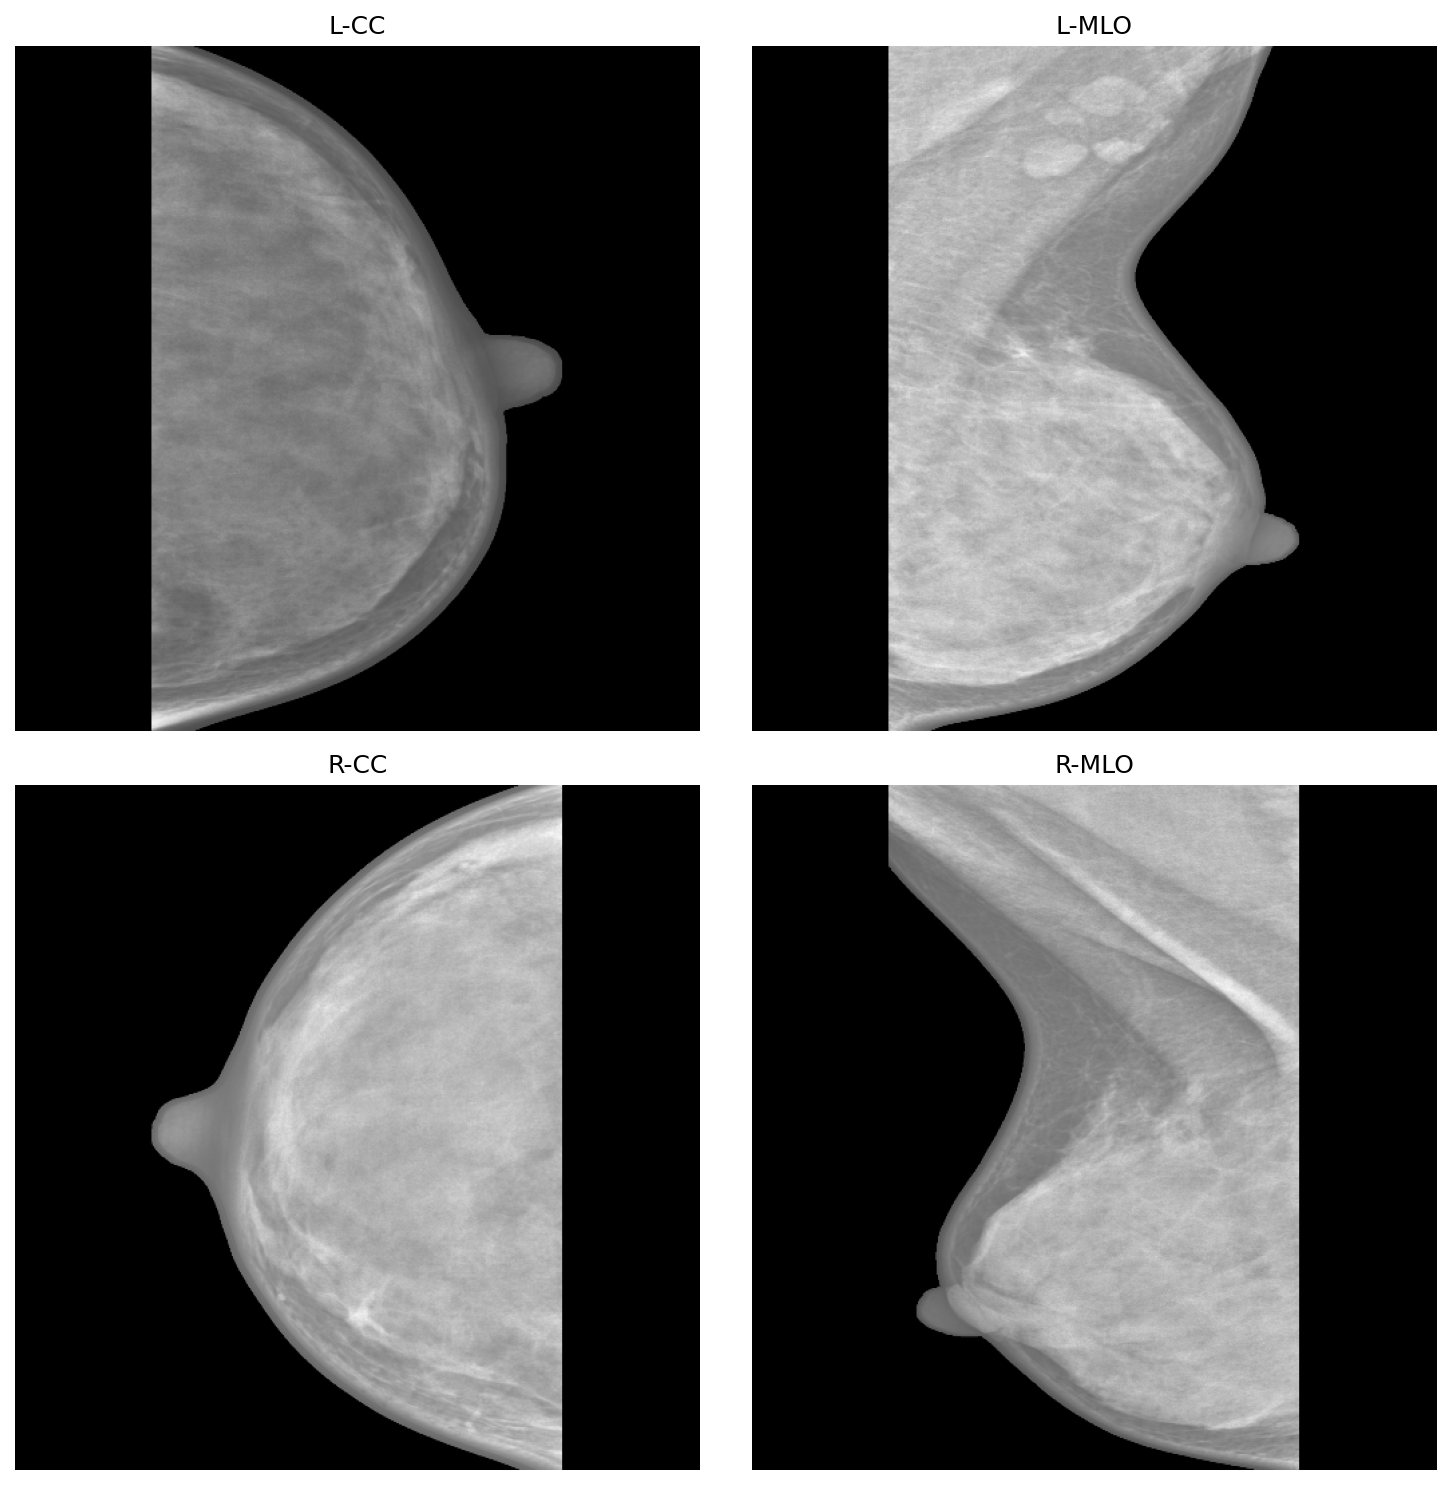

In [ ]:
def sanity_check_dataset(dataset: tf.data.Dataset, config: Dict, num_samples: int = 3):

    print("Running dataset sanity check...")

    # Take a batch
    for inputs, targets in dataset.take(1):
        L_CC, L_MLO, R_CC, R_MLO, tabular = inputs
        birads, density = targets

        print(f"Batch shapes:")
        print(f"  L_CC: {L_CC.shape}")
        print(f"  L_MLO: {L_MLO.shape}")
        print(f"  R_CC: {R_CC.shape}")
        print(f"  R_MLO: {R_MLO.shape}")
        print(f"  Tabular: {tabular.shape}")
        print(f"  BI-RADS targets: {birads.shape}")
        print(f"  Density targets: {density.shape}")

        # Check value ranges
        print(f"\nValue ranges:")
        print(f"  L_CC: [{L_CC.numpy().min():.3f}, {L_CC.numpy().max():.3f}]")
        print(f"  Tabular: mean={tabular.numpy().mean():.3f}, std={tabular.numpy().std():.3f}")

        # Display sample images
        fig, axes = plt.subplots(2, 2, figsize=(10, 10))
        views = [("L-CC", L_CC), ("L-MLO", L_MLO), ("R-CC", R_CC), ("R-MLO", R_MLO)]

        for ax, (title, img) in zip(axes.flat, views):
            ax.imshow(img[0].numpy(), cmap='gray')
            ax.set_title(title)
            ax.axis('off')

        plt.tight_layout()
        plt.show()

        break

# Run sanity check
sanity_check_dataset(train_dataset, CONFIG)

Save Dataset Artifacts

In [ ]:
def save_dataset_artifacts(view_df: pd.DataFrame, config: Dict):

    artifact_dir = config['output_dir'] / 'artifacts'
    artifact_dir.mkdir(exist_ok=True)

    # Save view mapping with splits
    view_df.to_csv(artifact_dir / 'view_mapping_final.csv', index=False)

    # Save class distributions
    split_stats = {}
    for split_name in ['train', 'val', 'test']:
        split_data = view_df[view_df['split_final'] == split_name]
        split_stats[split_name] = {
            'num_studies': split_data['study_id'].nunique(),
            'num_exams': len(split_data),
            'birads_dist': split_data['breast_birads_L_CC'].value_counts().to_dict(),
            'density_dist': split_data['breast_density_L_CC'].value_counts().to_dict(),
        }

    with open(artifact_dir / 'split_statistics.json', 'w') as f:
        json.dump(split_stats, f, indent=2, default=str)

    print(f"Artifacts saved to {artifact_dir}")
    print("\nSplit statistics:")
    print(json.dumps(split_stats, indent=2, default=str))

# Save artifacts
save_dataset_artifacts(view_mapping_df, CONFIG)

Artifacts saved to /content/drive/MyDrive/VnDir_Mammo/sanvia_outputs/artifacts

Split statistics:
{
  "train": {
    "num_studies": 4000,
    "num_exams": 4000,
    "birads_dist": {
      "1": 2652,
      "2": 951,
      "3": 193,
      "4": 163,
      "5": 41
    },
    "density_dist": {
      "2": 3057,
      "3": 542,
      "1": 381,
      "0": 20
    }
  },
  "val": {
    "num_studies": 500,
    "num_exams": 500,
    "birads_dist": {
      "1": 340,
      "2": 110,
      "3": 23,
      "4": 19,
      "5": 8
    },
    "density_dist": {
      "2": 380,
      "3": 70,
      "1": 47,
      "0": 3
    }
  },
  "test": {
    "num_studies": 500,
    "num_exams": 500,
    "birads_dist": {
      "1": 336,
      "2": 112,
      "3": 25,
      "4": 22,
      "5": 5
    },
    "density_dist": {
      "2": 384,
      "3": 66,
      "1": 49,
      "0": 1
    }
  }
}


Final Summary and Notebook 1 Completion

In [ ]:
print("=" * 60)
print("SANVIA DATA PIPELINE - NOTEBOOK 1 COMPLETION SUMMARY")
print("=" * 60)

print(f"\n✅ Environment configured")
print(f"✅ Data loaded and cleaned: {breast_df.shape[0]} annotations")

print(f"✅ Patient-level splits created: "
      f"{view_mapping_df[view_mapping_df['split_final']=='train']['study_id'].nunique()} train, "
      f"{view_mapping_df[view_mapping_df['split_final']=='val']['study_id'].nunique()} val, "
      f"{view_mapping_df[view_mapping_df['split_final']=='test']['study_id'].nunique()} test")

print(f"✅ Class weights computed and saved")
print(f"✅ Tabular scaler fitted and saved")
print(f"✅ tf.data pipelines built for train/val/test")
print(f"✅ Oversampling strategy implemented")
print(f"✅ Augmentation pipeline ready")

print(f"\n📁 Output directory: {CONFIG['output_dir']}")
print(f"📊 Next: Run Notebook 2 for model training")
print("=" * 60)

SANVIA DATA PIPELINE - NOTEBOOK 1 COMPLETION SUMMARY

✅ Environment configured
✅ Data loaded and cleaned: 20000 annotations
✅ Patient-level splits created: 4000 train, 500 val, 500 test
✅ Class weights computed and saved
✅ Tabular scaler fitted and saved
✅ tf.data pipelines built for train/val/test
✅ Oversampling strategy implemented
✅ Augmentation pipeline ready

📁 Output directory: /content/drive/MyDrive/VnDir_Mammo/sanvia_outputs
📊 Next: Run Notebook 2 for model training
